<a href="https://colab.research.google.com/github/natalie-rgb/teamTOM/blob/master/Projekt_UNet_Grupa9_z_errorem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! curl -s https://packagecloud.io/install/repositories/github/git-lfs/script.deb.sh | sudo bash
! sudo apt-get install git-lfs
! git lfs install
! git clone https://github.com/neheller/kits19.git

Detected operating system as Ubuntu/bionic.
Checking for curl...
Detected curl...
Checking for gpg...
Detected gpg...
Running apt-get update... done.
Installing apt-transport-https... done.
Installing /etc/apt/sources.list.d/github_git-lfs.list...done.
Importing packagecloud gpg key... done.
Running apt-get update... done.

The repository is setup! You can now install packages.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 46 not upgraded.
Need to get 6,877 kB of archives.
After this operation, 16.4 MB of additional disk space will be used.
Get:1 https://packagecloud.io/github/git-lfs/ubuntu bionic/main amd64 git-lfs amd64 2.11.0 [6,877 kB]
Fetched 6,877 kB in 1s (7,878 kB/s)
debconf: unable to ini

In [2]:
%cd kits19
!pip3 install -r /content/kits19/requirements.txt
! python -m starter_code.get_imaging

/content/kits19
300 cases to download...
Download 1/300: 
case_00000: 100% 225959/225960 [00:14<00:00, 15220.02KB/s]
Download 2/300: 
case_00001: 100% 276387/276388 [00:14<00:00, 19314.36KB/s]
Download 3/300: 
case_00002: 100% 101967/101968 [00:07<00:00, 13991.12KB/s]
Download 4/300: 
case_00003: 100% 118681/118682 [00:08<00:00, 14365.17KB/s]
Download 5/300: 
case_00004: 100% 25269/25270 [00:02<00:00, 10317.39KB/s]
Download 6/300: 
case_00005: 100% 313477/313478 [00:20<00:00, 15364.17KB/s]
Download 7/300: 
case_00006: 100% 78010/78011 [00:05<00:00, 13409.84KB/s]
Download 8/300: 
case_00007:   7% 1806/25827 [00:00<00:11, 2015.66KB/s]
KeyboardInterrupt


In [10]:
%cd /content/kits19/

/content/kits19


In [0]:
import os
train_path = "/content/kits19/data/case_00000"
cases =  next(os.walk(train_path))


In [0]:
input_filename = os.path.join(train_path, cases[2][-1])
gt_filename = os.path.join(train_path, cases[2][0]) 

In [13]:
gt_filename


'/content/kits19/data/case_00000/segmentation.nii.gz'

In [14]:
!pip install medicaltorch

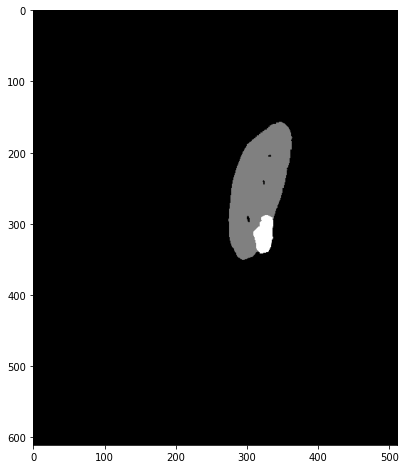

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
from medicaltorch import datasets as mt_datasets
from skimage import color
pair = mt_datasets.SegmentationPair2D(input_filename, gt_filename) 
slice_pair = pair.get_pair_slice(175)
input_slice = slice_pair["input"]
gt_slice = slice_pair["gt"]

img = input_slice
label = gt_slice
plt.imshow(label, cmap = 'gray')
plt.show()


In [17]:
import numpy as np
np.unique(label)  #ile wyróżnia nam klas

array([0., 1., 2.], dtype=float32)

In [18]:
import torch
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler, Adam, SGD
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from medicaltorch import models as mt_models
from keras.utils import to_categorical as cat
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

Using TensorFlow backend.


device(type='cuda')

In [0]:
import os
train_path = "/content/kits19/data/"
cases =  next(os.walk(train_path))
file_name = cases[1]

In [0]:
model = mt_models.Unet(drop_rate=0.4, bn_momentum=0.1)

In [21]:
model

Unet(
  (conv1): DownConv(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1_drop): Dropout2d(p=0.4, inplace=False)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2_drop): Dropout2d(p=0.4, inplace=False)
  )
  (mp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): DownConv(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1_drop): Dropout2d(p=0.4, inplace=False)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2

In [0]:
def transform(img, lbl):
    img = img.astype(float)
    lbl = lbl.astype(float)
    img -= np.mean(img)
    img /= 255.0
    img = np.resize(img, (224, 224))  
    img = torch.from_numpy(img).unsqueeze_(0)
    print('Img shape:', img.shape)
    lbl = np.resize(lbl, (224, 224))  
    lbl = torch.from_numpy(lbl).unsqueeze_(0)
    print('Label shape:', lbl.shape)
    
    return img, lbl

In [0]:

class TrainDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.transform = transform
        
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        global image
        global classes
        cases = file_name[idx]
        file_path = train_path + cases +'/'
        content = next(os.walk(file_path))
        if 'segmentation.nii.gz' not in content[2]:
          pass
        else:
          input_filename = file_path + content[2][-1]
          gt_filename = file_path + content[2][0]
          pair = mt_datasets.SegmentationPair2D(input_filename, gt_filename)
          slice_pair = pair.get_pair_slice(175)
          image = slice_pair["input"]
          classes = slice_pair["gt"]
          image,classes = transform(image, classes)
          

        return image, classes  
  

In [0]:
train_dataset = TrainDataset(file_name) 
train_loader = DataLoader(train_dataset, batch_size=2, num_workers=0)

In [0]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [26]:

for data, label in train_loader:
    print ("list data:")
    print (data)
    print (label)
    break

Img shape: torch.Size([1, 224, 224])
Label shape: torch.Size([1, 224, 224])
Img shape: torch.Size([1, 224, 224])
Label shape: torch.Size([1, 224, 224])
list data:
tensor([[[[-1.2895e-04, -1.2895e-04, -1.2895e-04,  ..., -1.2895e-04,
           -1.2895e-04, -1.2895e-04],
          [-1.2895e-04, -1.2895e-04, -1.2895e-04,  ..., -1.2895e-04,
           -1.2895e-04, -1.2895e-04],
          [-1.2895e-04, -1.2895e-04, -1.2895e-04,  ..., -1.2895e-04,
           -1.2895e-04, -1.2895e-04],
          ...,
          [-1.2895e-04, -1.2895e-04, -1.2895e-04,  ..., -1.2895e-04,
           -1.2895e-04, -1.2895e-04],
          [-1.2895e-04, -1.2895e-04, -1.2895e-04,  ..., -1.2895e-04,
           -1.2895e-04, -1.2895e-04],
          [-1.2895e-04, -1.2895e-04, -1.2895e-04,  ..., -1.2895e-04,
           -1.2895e-04, -1.2895e-04]]],


        [[[-7.4417e-05, -7.4417e-05, -7.4417e-05,  ..., -7.4417e-05,
           -7.4417e-05, -7.4417e-05],
          [-7.4417e-05, -7.4417e-05, -7.4417e-05,  ..., -7.4417e-05,


In [29]:

train_loss_total = 0 
num_epochs = 4 
model.to(device) 

for epoch in range(num_epochs): 
  print('Epoch has started') 
  for data, label in iter(train_loader): 
    data.to(device) 
    label.to(device) 
    print('step 1 check')
    outputs = model(data) 
    loss = criterion(outputs, label) 
    loss.backward() 
    print('step 2 check')
    optimizer.step() 
  train_loss_total += loss.item() 
  train_loss_total_avg = train_loss_total / len(train_loader) 
  print('epoch number ', epoch, "					",'Error term', train_loss_total_avg)


Epoch has started
Img shape: torch.Size([1, 224, 224])
Label shape: torch.Size([1, 224, 224])
Img shape: torch.Size([1, 224, 224])
Label shape: torch.Size([1, 224, 224])
step 1 check


RuntimeError: ignored